+---+----------+---------+----------+-----+-----------+
| id|      date|store_nbr|    family|sales|onpromotion|
+---+----------+---------+----------+-----+-----------+
|  0|2013-01-01|        1|AUTOMOTIVE|  0.0|          0|
|  1|2013-01-01|        1| BABY CARE|  0.0|          0|
|  2|2013-01-01|        1|    BEAUTY|  0.0|          0|
|  3|2013-01-01|        1| BEVERAGES|  0.0|          0|
|  4|2013-01-01|        1|     BOOKS|  0.0|          0|
+---+----------+---------+----------+-----+-----------+
only showing top 5 rows

+---+----------+---------+----------+-----+-----------+-------+
| id|      date|store_nbr|    family|sales|onpromotion|    mes|
+---+----------+---------+----------+-----+-----------+-------+
|  0|2013-01-01|        1|AUTOMOTIVE|  0.0|          0|2013-01|
|  1|2013-01-01|        1| BABY CARE|  0.0|          0|2013-01|
|  2|2013-01-01|        1|    BEAUTY|  0.0|          0|2013-01|
|  3|2013-01-01|        1| BEVERAGES|  0.0|          0|2013-01|
|  4|2013-01-01|       

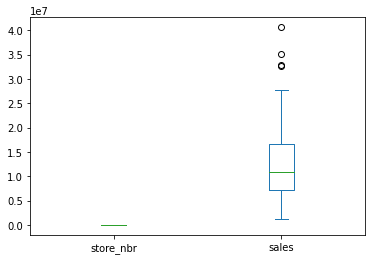

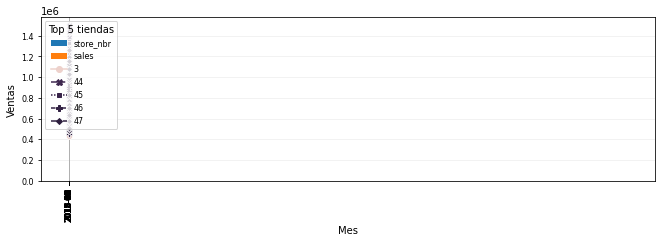

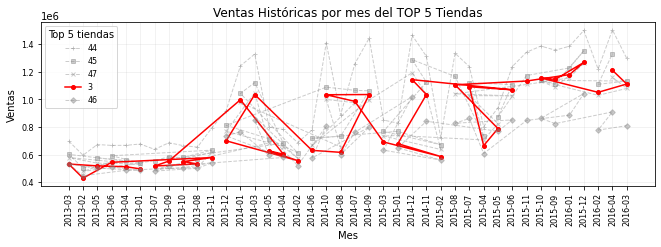

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, substring
import seaborn as sns
import matplotlib.pyplot as plt

# Iniciar Spark Session
spark = SparkSession.builder.appName("VentasTienda").getOrCreate()

# Cargar el archivo CSV
df = spark.read.option("header", "true").csv('/FileStore/tables/tienda_ventas.csv', inferSchema=True)

# Ver las primeras filas
df.show(5)

# Crear una columna 'mes' para extraer el mes y año de la columna 'date'
df = df.withColumn('mes', substring(col('date'), 1, 7))

# Ver las primeras filas con la nueva columna
df.show(5)

# Obtener el número de tiendas únicas
df.select('store_nbr').distinct().count()

# Agrupar por tienda y sumar las ventas
agrupado_tiendas = df.groupBy('store_nbr').agg({'sales': 'sum'}).withColumnRenamed('sum(sales)', 'sales')

# Mostrar los datos agregados
agrupado_tiendas.show()

# Obtener estadísticas descriptivas
agrupado_tiendas.describe().show()

# Filtrar la tienda con ventas 0 (en este caso se eliminaría la tienda 52)
agrupado_tiendas = agrupado_tiendas.filter(agrupado_tiendas.store_nbr != 52)

# Mostrar el diagrama de cajas
agrupado_tiendas.toPandas().plot.box()

# Mostrar el histograma
agrupado_tiendas.toPandas().plot.hist(bins=20)

# Ordenar las tiendas por ventas
agrupado_tiendas.sort('sales', ascending=False).show()

# Definir las tiendas de interés
top_5_tiendas = [44, 45, 47, 3, 46]

# Filtrar el DataFrame para incluir solo las tiendas del top 5
df_top_5 = df.filter(df.store_nbr.isin(top_5_tiendas))

# Agrupar por tienda y mes
top_5_por_mes = df_top_5.groupBy('store_nbr', 'mes').agg({'sales': 'sum'}).withColumnRenamed('sum(sales)', 'sales')

# Convertir a pandas para usar seaborn
top_5_por_mes_pd = top_5_por_mes.toPandas()

# Graficar el histórico de ventas
ax = sns.lineplot(
    data=top_5_por_mes_pd,
    x='mes',
    y='sales',
    hue='store_nbr',
    style='store_nbr',
    markers=True,
)

# Personalizar el gráfico
ax.tick_params(axis='x', labelrotation=90, labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.grid(visible=True, axis='x', alpha=0.2)
ax.grid(visible=True, axis='y', alpha=0.2)
ax.legend(title='Top 5 tiendas', bbox_to_anchor=(0, 1), fontsize=8, loc='upper left')
ax.set_ylabel('Ventas')
ax.set_xlabel('Mes')

# Ajustar tamaño de la figura
fig = ax.get_figure()
fig.set_size_inches(11, 3)

# Resaltar tienda 3
estilos_por_tienda = {
    44: ['grey', 0.4, '+', '--', 1],
    45: ['grey', 0.4, 's', '--', 1],
    47: ['grey', 0.4, 'x', '--', 1],
    3: ['red', 1, 'o', '-', 1.5],
    46: ['grey', 0.4, 'D', '--', 1]
}

# Crear gráfico con personalización
fig2, ax2 = plt.subplots()

for tienda in top_5_tiendas:
    estilos = estilos_por_tienda[tienda]
    df_tmp = top_5_por_mes_pd[top_5_por_mes_pd['store_nbr'] == tienda]
    
    ax2.plot(
        df_tmp['mes'],
        df_tmp['sales'],
        label=tienda,
        markersize=4,
        color=estilos[0],
        alpha=estilos[1],
        marker=estilos[2],
        linestyle=estilos[3],
        linewidth=estilos[4],
    )

ax2.tick_params(axis='x', labelrotation=90, labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.grid(visible=True, axis='x', alpha=0.2)
ax2.grid(visible=True, axis='y', alpha=0.2)
ax2.legend(title='Top 5 tiendas', labels=top_5_tiendas, bbox_to_anchor=(0, 1), fontsize=8, loc='upper left')
ax2.set_ylabel('Ventas')
ax2.set_xlabel('Mes')
ax2.set_title('Ventas Históricas por mes del TOP 5 Tiendas')

fig2.set_size_inches(11, 3)
plt.show()
